# Дипломная работа по курсу "Python для анализа данных"


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

rcParams['font.size'] = 14

## 1. Загрузка файла HR.csv в pandas dataframe

In [26]:
df = pd.read_csv('HR.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2. Расчет основных статистик для переменных

In [21]:
df_description = df.describe()

In [22]:
# Добавим строку с модой
mode_row = pd.Series(data={column: df[column].mode()[0] for column in df.columns}, name='mode')
df_description.append(mode_row, ignore_index=False)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,NaN,NaN
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,NaN,NaN
mode,0.100000,0.550000,4.000000,135.000000,3.000000,0.000000,0.000000,0.000000,sales,low


## 3. Анализ корреляции переменных

In [44]:
# Так как для нашего анализа не важно направление корреляции, берем значения по модулю
corr = df[['satisfaction_level', 'last_evaluation', 'number_project',
           'average_montly_hours', 'time_spend_company']].corr().abs()

In [50]:
corr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,0.142970,0.020048,0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,0.100866,0.131591,0.196786,0.127755,1.000000


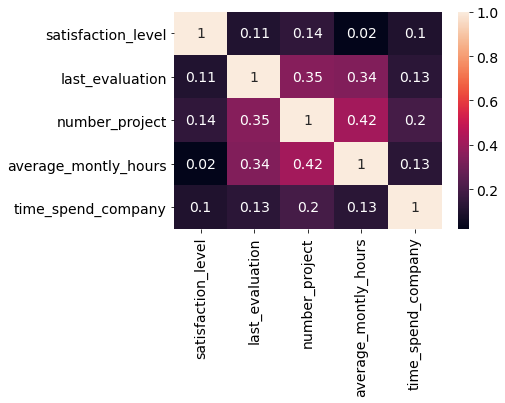

In [66]:
sns.heatmap(corr, annot = True)

### Выводы:
**Самые скоррелированные переменные (0,42)**: number_projects и average_monthly_hours\
**Наименее скоррелированные переменные (0,02)**: satisfaction_level и average_monthly_hours

## 4. Количество сотрудников в департаментах

In [58]:
departments_staff = df.groupby('department').count().iloc[:,:1]
departments_staff.columns = ['Количество сотрудников']
departments_staff.index.name = 'Департамент'

In [59]:
departments_staff

,Количество сотрудников
Департамент,
IT,1227
RandD,787
accounting,767
hr,739
management,630
marketing,858
product_mng,902
sales,4140
support,2229


## 5. Распределение сотрудников по зарплатам

Text(0, 0.5, 'Количество сотрудников')

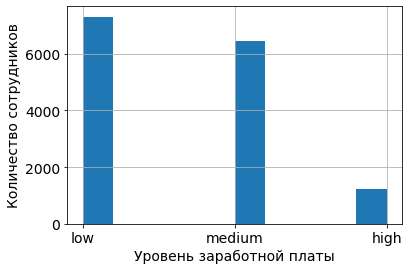

In [65]:
ax = df.salary.hist()
ax.set_xlabel('Уровень заработной платы')
ax.set_ylabel('Количество сотрудников')

## 6. Распределение сотрудников по зарплатам в каждом департаменте

In [83]:
departments = df.department.unique()

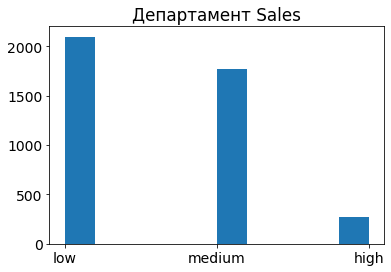

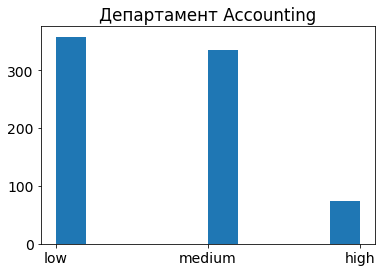

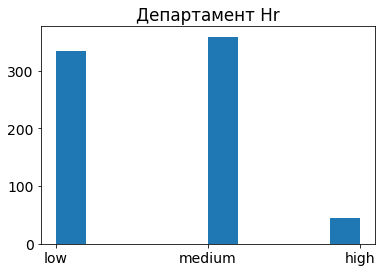

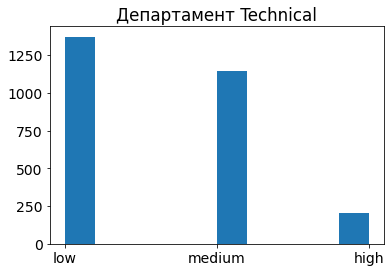

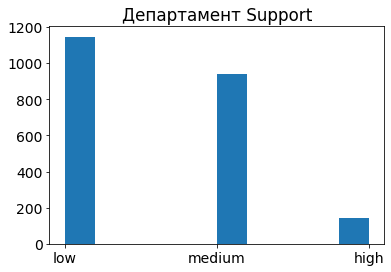

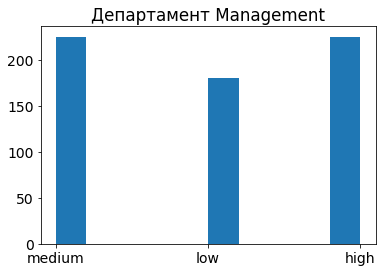

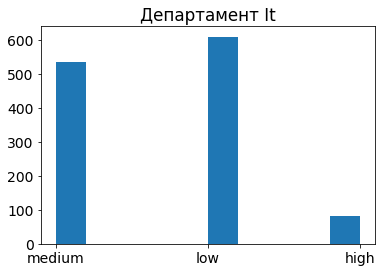

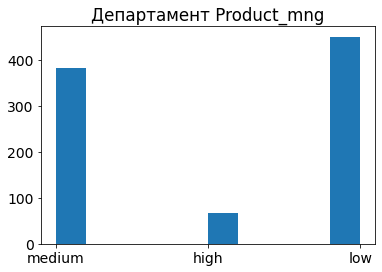

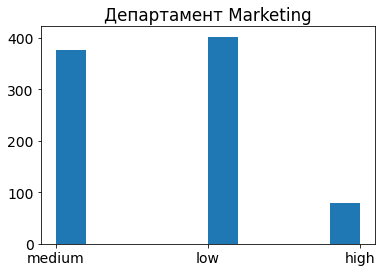

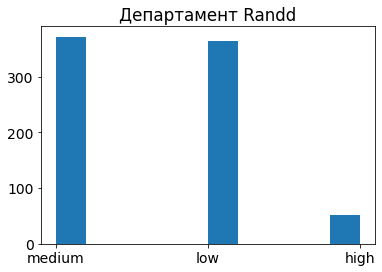

In [92]:
for dep in departments:
    plt.hist(df[df['department'] == dep]['salary'])
    plt.title(f'Департамент {dep.capitalize()}')
    plt.show()

## 7. Проверка гипотезы о положительной связи между временем, проведенным на работе, и уровнем заработной платы

Гипотеза H0 - сотрудники с высоким и низким уровнем заработной платы проводят на работе примерно одинаковое количество времени\
Гипотеза H1 - сотрудники с высоким и низким уровнем заработной платы проводят на работе разное количество времени

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb16810d790>]],
      dtype=object)

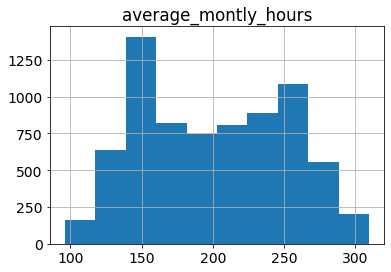

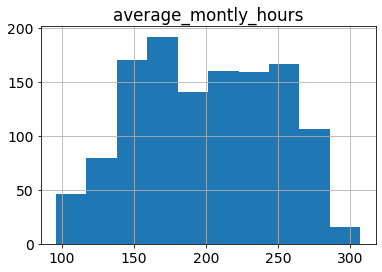

In [108]:
low_salary = df[df['salary'] == 'low'][['average_montly_hours']]
high_salary = df[df['salary'] == 'high'][['average_montly_hours']]

low_salary.hist()
high_salary.hist()

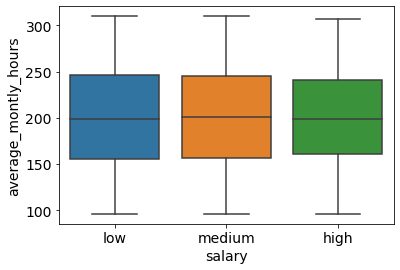

In [103]:
sns.boxplot(x=df["salary"], y=df["average_montly_hours"])

На графиках значительных отличий по времени работы между сотрудниками с разными уровнями зарплат не видно.
Воспользуемся критерием Стьюдента, чтобы увидеть, есть ли искомые различия.

In [96]:
import scipy.stats as stats

In [100]:
t, p = stats.ttest_ind(low_salary, high_salary)
t, p

(array([0.72886804]), array([0.46610235]))

### Выводы:
Большое значение pvalue говорит о том, что мы не можем отвергнуть H0. Иначе говоря, между выборками статистически значимых различий не обнаружено. На основе имеющихся данных мы не можем принять гипотезу о том, что сотрудники с более высоким окладом проводят больше времени на работе.

## 8. Показатели уволившихся и продолжающих работу сотрудников

In [143]:
metrics = df.groupby('left').mean()[['promotion_last_5years',
                                     'satisfaction_level',
                                     'number_project']].round(4)
metrics.promotion_last_5years *= 100
metrics.satisfaction_level *= 100                                     
metrics.columns = ['Получили повышение за последние 5 лет, %',
                   'Средняя удовлетворенность, %',
                   'Среднее количество проектов']                                     
metrics.index = ['Работающие', 'Уволившиеся']
metrics.index.name = 'Сотрудники:'
metrics

,"Получили повышение за последние 5 лет, %","Средняя удовлетворенность, %",Среднее количество проектов
Сотрудники:,,,
Работающие,2.63,66.68,3.7867
Уволившиеся,0.53,44.01,3.8555


## 9. Модель LDA

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [128]:
data = df.drop(columns=['department', 'salary', 'left'])
data_class = df['left']

In [129]:
# Разбиваем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data, data_class, test_size=0.25)

In [131]:
lda = LinearDiscriminantAnalysis()

In [132]:
# обучаем модель
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [133]:
# делаем прогноз на тестовой выборке
classes = lda.predict(X_test)

In [135]:
from sklearn.metrics import accuracy_score

In [136]:
# Точность предсказания
accuracy_score(y_test, classes)

0.7733333333333333